# Stacked Classifier - Optuna

This notebook will perfrom AutoML with Bayesian inference to determine the best possible estimator for classification problem.
The best estimaotrs are also aggregated using a meta learner in order to generate a stacked classifier. Given the time complexity
of the problem at hand, the stacked classifier class can perfrom prarallel trials on multiple machines:
$\textit{This requires to setup a proper connection to a database, see the function "database_location" of the StackedClassifier class}$

The StackedClassifier class is very flexibile, and can accomodate any type of "in-fold" operation, such as the normalization of the input features, the oversampling of the minority classes and so on. To check the parameters that are explored by Optuna trial, check "./script/model_optuna.py".

Addiontally, this script is also used to perfrom some form of model evaluation, by plotting the results against unseen experimental conditions

In [1]:
#For development
#Reload the library when a change is detected in one of the imported libraries
%load_ext autoreload 
%autoreload 2 

In [2]:
from script import stacking
from script import utils
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('Data/Train_bronze.csv') #Train Dataset
df = utils.bronze_to_silver(df)
df.head()

,P,T,DenL,DenG,VisL,VisG,ST,ID,Roughness,Ang,Vsl,Vsg,Flow_label
0,100.0,25.0,1000.000000,1.18,0.001000,0.000015,0.070,0.0250,0.0,70.0,0.978658,2.406290,2.0
1,100.0,25.0,1000.000000,1.18,0.001000,0.000015,0.070,0.0250,0.0,15.0,1.670240,0.392419,2.0
2,100.0,25.0,1000.000000,1.18,0.001000,0.000015,0.070,0.0250,0.0,-1.0,1.600000,0.016000,1.0
3,350.0,22.0,860.000000,4.13,0.007000,0.000010,0.032,0.0258,0.0,0.0,0.620824,0.876987,2.0
4,3223.0,52.9,791.498787,23.20,0.003218,0.000013,0.015,0.0549,0.0,0.0,0.284927,4.446000,0.0


In [4]:
kept_columns = ['Ang', 'FrL', 'FrG', 'X_LM', 'Eo', 'Flow_label'] #Kept Columns (problem specific)
algos = ["LightGBM"] #Algos to explore

## Create a Stacked Classifier object

An object of the StackingClassifier class is initiatied, it contains info about the models to explore, the column to keep, and the in-fold operations to perform during the optimization of the models

In [5]:
sc = stacking.StackedClassifier(base_algos=algos, balance_method=SMOTE(),
                                database_loc='local', cv=5)

### Optimize the Base Models

We can now optimize the models using the train dataframe. Feed a dataframe (where the last column is the target) and a number of trials to explore for each algo. Go run a marathon, when you are back if you are lucky the AutoML process will be compleated. You can interrupt this process at any time, no information will be lost. If you already have a trained base, just set the second argument to -1

In [6]:
sc.optimize_base(df, -1, kept=kept_columns)

[I 2021-07-12 21:55:31,858] Using an existing study with name 'LightGBM optimization' instead of creating a new one.


In [7]:
pd.read_parquet('results/info/logs.parquet').groupby('Algo').max()

,ID,Accuracy,Accuracy_std,F1_score,F1_score_std
Algo,,,,,
LightGBM,LightGBM_9,0.951281,0.016146,0.946004,0.018456
MLP,MLP_39,0.893771,0.018185,0.848130,0.018523


### Optimize the Meta-Learner

Optimize the meta learner using the exact same approach as before.

In [8]:
sc.train_meta('RandomForest', 1)

[I 2021-07-12 21:55:32,291] A new study created in memory with name: RandomForest meta optimization
[I 2021-07-12 21:55:33,343] Trial 0 finished with value: 0.9512796509189752 and parameters: {'n_estimators': 90, 'criterion': 'entropy', 'max_depth': 7}. Best is trial 0 with value: 0.9512796509189752.


### Train and Save the Base Models

We are now ready to train and save the best models found using all the training data

In [9]:
df_train = pd.read_csv('Data/Train_bronze.csv')
df_train = utils.bronze_to_gold(df_train, balance_method=SMOTE(), kept_columns=kept_columns)
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,[-1]].values.ravel()

first_it = True
if first_it:
    #Train
    sc.train_base(X_train, y_train, remove_old=True)
else:
    #Load
    sc.load_base()

In [10]:
def predict_df(df_bronze, n_class=6):
    
    '''
    Simple function to check the performance of the single
    estimators on the test data
    '''
    
    df_gold = utils.bronze_to_gold(df_bronze, kept_columns=kept_columns)
    
    X_test = df_gold.iloc[:,:-1].values    
    y_test = df_gold.iloc[:,[-1]].values.ravel()
    
    for algo, model in sc.get_base().items():
        print(algo)
        if algo=="MLP":
            with tf.device('/cpu:0'):
                y_pred = model.predict(X_test).argmax(1)
        else:
            y_pred = model.predict(X_test)
        
        if n_class==4:
            y_pred = np.where(y_pred==5, 1, y_pred)
            y_pred = np.where(y_pred==4, 3, y_pred)
        
        utils.print_performance(y_test, y_pred)
    
    print('StackedClassifier')
    y_pred = sc.predict(X_test)
    if n_class==4:
        y_pred = np.where(y_pred==5, 1, y_pred)
        y_pred = np.where(y_pred==4, 3, y_pred)
    
    utils.print_performance(y_test, y_pred)
    

## Model Evaluation

We can now use the single estimators to check the performance on the test set. This is just a final check, and if everything went smoothly, the best single estimator will be the best performing one.

In [11]:
df_test_same = pd.read_csv('Data/Test_bronze.csv')
predict_df(df_test_same)

LightGBM
Mean Accuracy:  0.9543773119605425
Mean F1 score:  0.949915259588702


Single class Accuracy:  [0.94249201 0.95512821 0.96269555 0.93925234 0.97402597 0.90322581]
Single class F1 score:  [0.93502377 0.94006309 0.96560048 0.94811321 0.96153846 0.94915254]

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       313
           1       0.93      0.96      0.94       156
           2       0.97      0.96      0.97       831
           3       0.96      0.94      0.95       214
           4       0.95      0.97      0.96        77
           5       1.00      0.90      0.95        31

    accuracy                           0.95      1622
   macro avg       0.95      0.95      0.95      1622
weighted avg       0.95      0.95      0.95      1622


Confusion Matrix:
 [[295   0  12   5   1   0]
 [  0 149   7   0   0   0]
 [ 14  12 800   4   1   0]
 [  8   0   3 201   2   0]
 [  1   0   1   0  75   0]
 [  0   0   

## Extra Evaluation

The test set was taken with respect to experimental coditions equal to the ones of the test set. It is clear that this does not really refect a real case scenario, where the experimental conditions may differ from the ones of the training dataset. To this end, the dataset from the study of Mexico numba one is used to test the pipeline with respect to previously unseen experimental conditions. It should be underlined that this dataset only contains 4 types of regimes, so the output of the pipeline have to be modified accordingly (by aggregating dispersed and stratified regimes)

In [12]:
df_train = pd.read_csv('Data/Dataset.csv')
df_train = utils.bronze_to_gold(df_train, balance_method=SMOTE(), kept_columns=kept_columns)
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,[-1]].values.ravel()

first_it = True
if first_it:
    #Train
    sc.train_base(X_train, y_train, remove_old=True)
else:
    #Load
    sc.load_base()

In [30]:
df_test_secret = pd.read_csv('Data/Secret/Test_secret.csv')
df_secret_ID = df_test_secret.loc[(df_test_secret["ID"]<0.08) & (df_test_secret["ID"]>0.01) & (df_test_secret['Ang']==0)]
predict_df(df_test_secret, n_class=4)

LightGBM
Mean Accuracy:  0.7219152854511971
Mean F1 score:  0.6790590734058963


Single class Accuracy:  [0.62759644 0.62133891 0.83932854 0.52968037]
Single class F1 score:  [0.68557536 0.60985626 0.78168621 0.63911846]

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.63      0.69       674
           1       0.60      0.62      0.61       478
           2       0.73      0.84      0.78      1668
           3       0.81      0.53      0.64       438

    accuracy                           0.72      3258
   macro avg       0.72      0.65      0.68      3258
weighted avg       0.73      0.72      0.72      3258


Confusion Matrix:
 [[ 423   36  200   15]
 [  15  297  166    0]
 [  71  156 1400   41]
 [  51    7  148  232]]
StackedClassifier
Mean Accuracy:  0.7249846531614488
Mean F1 score:  0.6835530891510633


Single class Accuracy:  [0.62759644 0.62133891 0.84532374 0.52968037]
Single class F1 score:  [0.68557536 0.6285714

## Results Visualization

It is now time to present the results in a respectable manner

In [31]:
import plotly.express as px
import plotly.graph_objects as go

In [32]:
algos = ["LightGBM"]

In [33]:
def bar_plot_studies(df_test, algos=algos, n_class=6):
    
    '''
    Another simple function to show the accuracy on the single studies
    '''
    
    author_list = list(df_test['Author'].value_counts().index)
    model_info = pd.DataFrame(index=author_list, columns=algos)

    for author in author_list:

        di = {}

        df_author = df_test.loc[(df_test['Author']==author)]
        df_author = utils.bronze_to_gold(df_author, kept_columns=kept_columns)
        X_test = df_author.iloc[:,:-1].values
        y_test = df_author.iloc[:,[-1]].values.ravel()

        for algo, model in sc.get_base().items():
            if algo=="MLP":
                with tf.device('/cpu:0'):
                    y_pred = model.predict(X_test).argmax(1)
            else:
                y_pred = model.predict(X_test)
            
            if n_class==4:
                y_pred = np.where(y_pred==5, 1, y_pred)
                y_pred = np.where(y_pred==4, 3, y_pred)
            
            di[algo] = accuracy_score(y_test, y_pred)
        
        y_pred = sc.predict(X_test)
        if n_class==4:
            y_pred = np.where(y_pred==5, 1, y_pred)
            y_pred = np.where(y_pred==4, 3, y_pred)
        
        di["StackedEnsamble"] = accuracy_score(y_test, y_pred)
        model_info.loc[author] = di 

    model_info = model_info.sort_index()
    fig = go.Figure(data=[go.Bar(name=algo, y=model_info[algo], x=model_info.index) for algo in algos])
    fig.update_yaxes(title="Accuracy")
    fig.update_xaxes(title="Independent Study", tickangle=45)
    fig.update_layout(barmode='group', title="Prediction Accuracy on different studies")
    
    fig.write_image(f"Plots/Others/prediction_accuracy_{len(author_list)}.png", scale=2)
    
    fig.show()
    
    return model_info

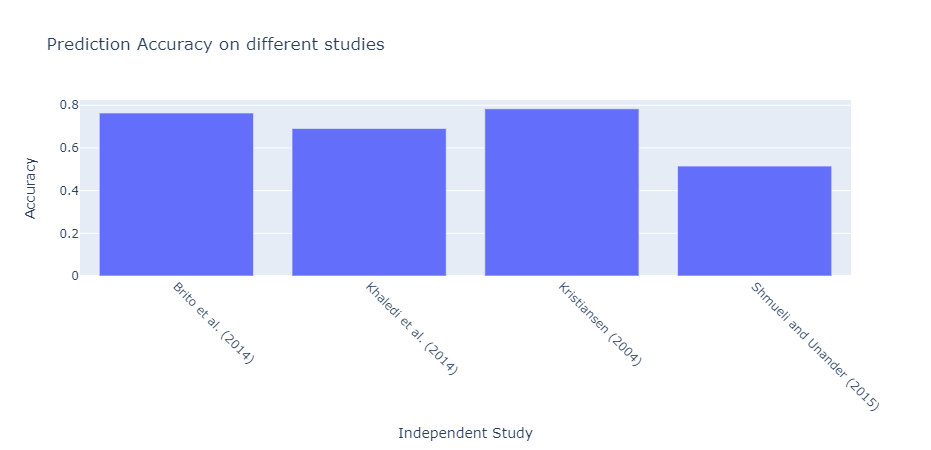

In [35]:
mi = bar_plot_studies(df_secret_ID, n_class=4)

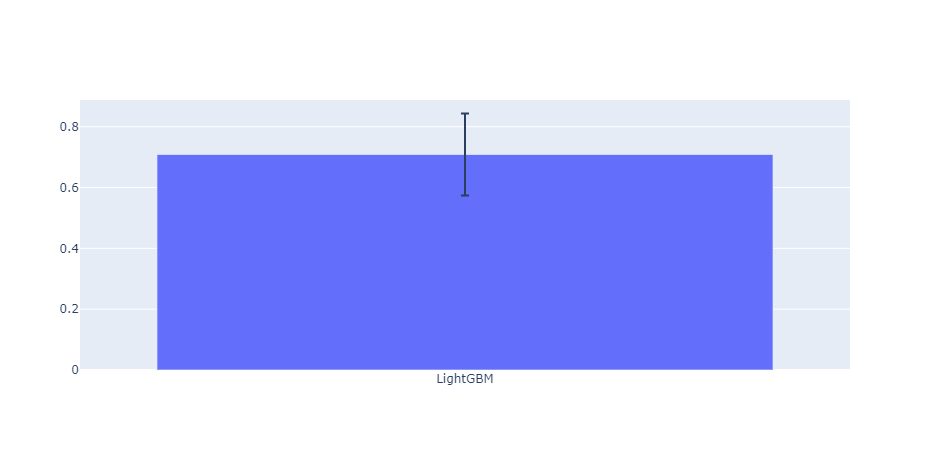

In [18]:
averages = pd.DataFrame({"mean" : mi.mean(), "std" : mi.std()})

fig = go.Figure(data=[go.Bar(name="Averages", 
                             y=averages["mean"], 
                             x=averages.index,
                             error_y=dict(type='data', array=averages['std']))])

fig.update_layout(barmode='group')
fig.show()